In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 卡尔曼滤波器（Kalman Filter，KF）算法及仿真

## 1. 贝叶斯滤波器

贝叶斯滤波器的算法如下所示：

----
1：**Algorithm Bayes_filter**$(bel(x_{t-1}), u_t, z_t)$**:**  
2：&emsp;&emsp;for all $x_t$ do  
3：&emsp;&emsp;&emsp;&emsp;$\overline {bel}(x_t) = \int p(x_t \, | \, u_t, x_{t-1})bel(x_{t-1})dx_{t-1}$  
4：&emsp;&emsp;&emsp;&emsp;$bel(x_t)=\eta p ( z_t | x_t) \overline {bel}(x_t)$  
5：&emsp;&emsp;end for  
6：&emsp;&emsp;**return** $bel(x_t)$  

----

**贝叶斯滤波**的生成模型也被称为**隐马尔科夫模型（Hidden Markov Model，HMM）**或**动态贝叶斯网络（Dynamic Bayes Network， DBN）**。

对于离散有限的状态空间，可以用所有可能状态的概率值来表示置信度。但是如果状态空间是无限或连续，则置信度难以表示。

通常有两种置信度的表示方法：
1. 用多元正态分布来表示置信度。对应的滤波算法被称统称为**高斯滤波（Gaussian Filter）**。  
2. 用粒子集来表示置信度。对应的滤波算法被称为**粒子滤波（Particle Filter）**。  

## 2. 卡尔曼滤波

KF算法用**矩**来定义置信度，可以对连续状态的置信度进行计算，但是不适用于离散状态空间和混合状态空间。

----
1：**Algorithm Kalman_filter**$( \mu, \Sigma_{t-1}, u_t, z_t )$**:**  
2：&emsp;&emsp;$\overline \mu_t = A_t \mu_{t-1} + B_t u_t$  
3：&emsp;&emsp;$\overline \Sigma_t = A_t \Sigma_{t-1}A_t^T + R_t$  
4：&emsp;&emsp;$K_t = \overline \Sigma_t C_t^T ( C_t \overline \Sigma_t C_t^T + Q_t)^{-1}$  
5：&emsp;&emsp;$\mu_t = \overline \mu_t + K_t (z_t - C_t \overline \mu_t)$  
6：&emsp;&emsp;$\Sigma_t = (I - K_t C_t) \overline \Sigma_t$  
7：&emsp;&emsp;**return** ${\mu_t, \Sigma_t}$  

----


## 3. Kalman Filter仿真


### 3.1 仿真模型

#### 3.1.1 问题描述

假设有一个沿直线运动的机器人，每隔一个时间间隔$\vartriangle t$，根据运动$u_t$对自己当前的状态进行预测（Predict），然后利用传感器获得的测量$z_t$对自己的状态进行更新（Update）。

定义机器人的状态$x_t = \begin{bmatrix}p_t \\ v_t \end{bmatrix}$，其中$p_t$表示机器人的位置，$v_t$表示机器人的速度。

#### 3.1.2 运动模型

假设机器人可以控制其加速度$a$，则运动迁移方程可以写为：
$$\begin{align}
p_t &= p_{t-1} + v_{t-1} \triangle t + \frac 12 a \triangle t^2  \\
v_t &= v_{t-1} + a \triangle t
\end{align}$$

把该方程改写为线性方程，可得：
$$\begin{align}
x_t &= \begin{bmatrix} p_t \\ v_t \end{bmatrix} = 
\begin{bmatrix} 1 & \triangle t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} p_{t-1} \\ v_{t-1} \end{bmatrix} +
\begin{bmatrix} \frac 12  \triangle t^2 \\ \triangle t \end{bmatrix}  a + \varepsilon_t
\\
 &= A_t x_{t-1} + B_t u_t + \varepsilon_t
\end{align}
$$

其中$\varepsilon_t$是控制带来的噪声，假设加速度$a$包含有一个$\sim N(\mu , \sigma_a^2)$的一个噪声。因此该噪声对机器人状态$x_t$带来的噪声可表示为：$ noise_u \sim N(\mu , R_t)$，其中$\mu = (0, 0)^T$，$R_t = \begin{bmatrix}\frac 12 \triangle t_2  & 0 \\ 0 & \triangle t \end{bmatrix} \sigma_u^2$。

#### 3.1.3 测量模型

贝叶斯滤波的测量模型并不是使用后验概率$p(x \, \vert \, z)$，而是用似然（likelihood）来进行计算。

假设该仿真模型中的机器人可以获得对当前位置的一个测量量$z_t$，因此可以得到测量模型为：
$$\begin{align}
z_t &= p_t + \delta_t \\
   &= \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} p_t \\ v_t \end{bmatrix} + \delta_t \\
   &= C_t x_t + \delta_t   
\end{align}$$

其中$\delta_t$是测量的噪声，该噪声遵从一个均值为0的高斯分布$\delta_t \sim N( \mu , \sigma_z^2)$。

## 3.2 仿真实验设计

### 3.2.1 采样函数

在真实的机器人系统中，当我们给定一个控制$u_t$，控制系统将会带有噪声的执行这个控制，在真实物理环境下我们的目的就是去恢复带噪声的执行结果。

在仿真的过程中，我们通过一些采样函数根据控制$u_t$来随机的采样，并将采样的结果作为真实的运动结果，然后就可以观察是否可以通过卡尔曼滤波来消除控制$u_t$所产生的累计噪声。

通常在采样的时候，我们使用正态分布（Normal Distribution）或者三角分布（Triangle Distribution）。

#### a) 正态分布/高斯分布

正态分布的密度函数为：
$$p(x) = \frac {1} {\sqrt{2 \pi \sigma_2}} e^{- \frac 12 \frac {(x - \mu)^2} {\sigma^2}}$$

由于在概率机器人模型中，通常假设分布的均值为$0$，因此均值为$0$的正态分布的密度函数为：
$$p(x) = \frac {1} {\sqrt{2 \pi \sigma_2}} e^{- \frac 12 \frac {x^2} {\sigma^2}}$$

正态分布的曲线如下所示：

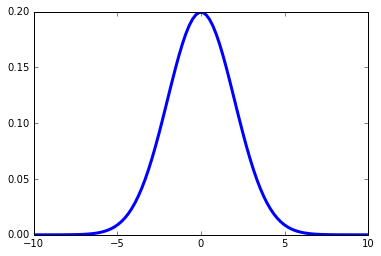

In [2]:
# 定义numpy风格向量运算版的正态分布概率密度函数
def probNormalDistribution(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- 0.5 * (x - mu) ** 2 / sigma ** 2)

# x的值取-10到10之间均匀分割的100个点
x = np.linspace(-10, 10, 100)

# 调用概率密度函数，均值为0，标准差为2，通过改变参数可以调整正态分布密度函数的形态
y = probNormalDistribution(x, 0, 2)

# 绘制正态分布概率密度函数
fig = plt.figure('Normal Distribution')
plt.plot(x, y, linewidth=3)

如果给定标准差，可以利用大数定律的方法来通过均匀分布的随机数来产生正态分布的采样，若$rand(\cdot , \cdot)$函数表示一个均匀分布的随机数产生器，则可以用下面的公式来产生遵从$\sim N (0 , \sigma^2)$的采样：
$$\frac 12 \sum_{i=1}^{12} rand(- \sigma , \sigma)$$

相关证明请参考《概率论与数理统计》课本中“大数定理”的章节。

In [3]:
def sampleNormalDistribution(sigma):
    return np.sum(np.random.uniform(-sigma, sigma, 12)) / 2

# 采样10000个样本，计算其直方图
samples = [sampleNormalDistribution(2) for i in range(10000)]

In [4]:
import matplotlib.path as path
import matplotlib.patches as patches

# 封装一个绘制bar图的函数，以方便绘制直方图
def drawHistChart(samples):
    n, bins = np.histogram(samples, 50, range=(-10, 10))

    # 获得直方图矩形的角点
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n

    # 构造一个(矩形数量 * 边数 * 2)的矩阵，用来生成组合路径
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # 获得路径对象
    barpath = path.Path.make_compound_path_from_polys(XY)

    # 获得路径
    patch = patches.PathPatch(barpath)

    # 绘图
    fig, ax = plt.subplots()
    ax.add_patch(patch)
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

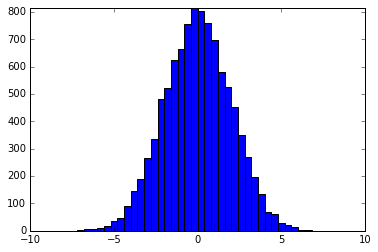

In [5]:
drawHistChart(samples)

此外，也可以直接使用Numpy的random模块中的normal函数来进行基于正态分布的采样：

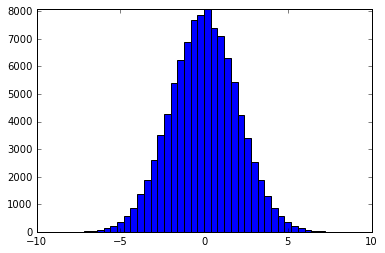

In [6]:
# 采样10000个样本，计算其直方图
samples = np.random.normal(0, 2, 100000)

drawHistChart(samples)

#### b) 三角分布

可以利用Numpy来生成三角分布的采样：

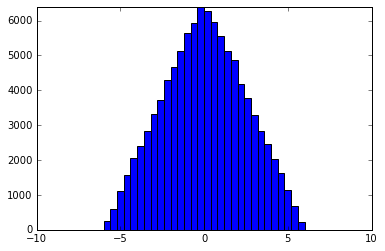

In [7]:
# 采样10000个样本，计算其直方图
samples = np.random.triangular(-6, 0, 6, 100000)

drawHistChart(samples)

### 3.2.2 运动采样

回忆之前的运动控制方程：
$$\begin{align}
x_t &= \begin{bmatrix} p_t \\ v_t \end{bmatrix} = 
\begin{bmatrix} 1 & \triangle t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} p_{t-1} \\ v_{t-1} \end{bmatrix} +
\begin{bmatrix} \frac 12  \triangle t^2 \\ \triangle t \end{bmatrix}  a + \varepsilon_t
\\
 &= A_t x_{t-1} + B_t u_t + \varepsilon_t
\end{align}
$$

为了仿真出机器人真实的路径，采用采样的方式来计算真实的机器人状态。在后面根据这个状态来获得观测。

In [8]:
# 控制采样函数，为简化模型我们选用delta t为1
sigma_u = 0.2
def sample_pose(x0, u, sigma):
    A = np.array([1, 1, 0, 1]).reshape((2, 2))
    B = np.array([0.5, 1]).reshape((2, 1))
    noise = np.random.normal(0, sigma)
    x0 = np.array(x0).reshape((2, 1))
    x1 = np.dot(A, x0) + B * u + B * noise
    return x1

sample_pose([0, 0], 1, sigma_u)

array([[ 0.46967034],
       [ 0.93934068]])

### 3.2.3 测量采样

在这个仿真实验中，机器人只有一个传感器，可以直接获得对机器人位置的测量，因此有下面的测量模型：
$$\begin{align}
z_t &= \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} p_t \\ v_t \end{bmatrix} + \delta_t \\
   &= C_t x_t + \delta_t   
\end{align}$$

In [9]:
# 测量采样函数
sigma_z = 0.1
def sample_measurement(x, sigma):
    C = np.array([1, 0]).reshape((1, 2))
    x = np.array(x).reshape((2, 1))
    noise = np.random.normal(0, sigma, size=(1, 1))
    z = np.dot(C, x) + noise
    return z

sample_measurement([1, 2], sigma_z)

array([[ 1.05816963]])